In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import interp1d
from scipy.special import spherical_jn
from tqdm import tqdm

from interaction import LocalSystem, potential
import constants as const
import utility
import bind

plt.style.use('science')
gr = 4/3
h = 3

In [2]:
lo_rg_flow = np.loadtxt('rgflow_local_lo_a0_fix.txt')
nlo_rg_flow = np.loadtxt('rgflow_local_nlo_a0_B6_fix.txt')

In [3]:
def alpha(r):
    return 9/2 - 2/3*np.exp(-2*r) * (r**5 + 9/2*r**4 + 9*r**3 + 27/2*r**2 + 27/2*r + 27/4)


def mm_potential(r):
    return -1/2 * alpha(r) / r**4


mm = LocalSystem(1.5)

mm_p_vtilde = utility.ft_matrix_gen(mm_potential, 1, 1, mm.q, mm.r_nodes, mm.r_weights)
mm_p_evals, mm_p_evecs = bind.bound_states(mm_p_vtilde, 0, 0, mm.q, mm.wq)

mm_d_vtilde = utility.ft_matrix_gen(mm_potential, 2, 2, mm.q, mm.r_nodes, mm.r_weights)
mm_d_evals, mm_d_evecs = bind.bound_states(mm_d_vtilde, 0, 0, mm.q, mm.wq)

In [4]:
def ftr(state, r, wr, q, wq, ell):
    y = np.array([np.sum(np.sqrt(2/np.pi) * wq * q**2 * state * spherical_jn(ell, q*ri)) for ri in r])
    return 1/np.sqrt(np.sum(wr * r**2 * y**2)) * y


def local_LO_counterterm(r, R):
    return np.exp(-(r/R)**4)


def psi0(ls, g, ii, full=False):
    evals, evecs = bind.bound_states(ls.v_tilde, ls.counterterm.gen(g, 0), 1, ls.q, ls.wq)
    psi0 = np.zeros(evals.size)
    for i in range(evals.size):
        psi = np.abs(ftr(evecs[:, i], ls.r_nodes, ls.r_weights, ls.q, ls.wq)) / ls.r_nodes
        if full:
            psi0[i] = np.sum(ls.r_weights * ls.r_nodes**2 * local_NLO_counterterm(ls.r_nodes, Ri) * psi**2)
        else:
            psi0[i] = psi[ii]**2
    return psi0


def psi_Vnlo_psi(evals, evecs, R, ell):
    overlap = np.zeros(evals.size)
    for i in range(evals.size):
        psi = np.abs(ftr(evecs[:, i], mm.r_nodes, mm.r_weights, mm.q, mm.wq, ell)) / mm.r_nodes
        overlap[i] = np.sum(mm.r_weights * mm.r_nodes**2 * local_LO_counterterm(mm.r_nodes, R) * psi**2)
    return overlap


def evals_and_evecs(g, ls):
    return bind.bound_states(ls.v_tilde, ls.counterterm.gen(g, 0), 1, ls.q, ls.wq)


class Spectrum:
    def __init__(self, ls, glo, gnlo):
        evals, evecs = bind.bound_states(ls.v_tilde, ls.counterterm.gen(glo, 0), 1, ls.q, ls.wq)
        self.lo_evals = np.copy(evals)
        self.lo_evecs = np.copy(evecs)
        self.R = ls.r_c
        self.glo = glo
        self.g_nlo = gnlo
        
        self.overlap = psi_Vnlo_psi(self.lo_evals, self.lo_evecs, self.R, ls.ell)
        self.nlo_evals = self.lo_evals + self.g_nlo*self.lo_evals*self.overlap

In [5]:
lo_p_wave = []
for (Ri, gi) in tqdm(lo_rg_flow):
    s = LocalSystem(Ri, ell=1)
    lo_p_wave.append(Spectrum(s, gi, 0))

100%|████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:28<00:00,  4.16s/it]


In [6]:
nlo_p_wave = []
for (Ri, gi, gj) in tqdm(nlo_rg_flow):
    s = LocalSystem(Ri, ell=1)
    nlo_p_wave.append(Spectrum(s, gi, gj))

100%|████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:29<00:00,  4.19s/it]


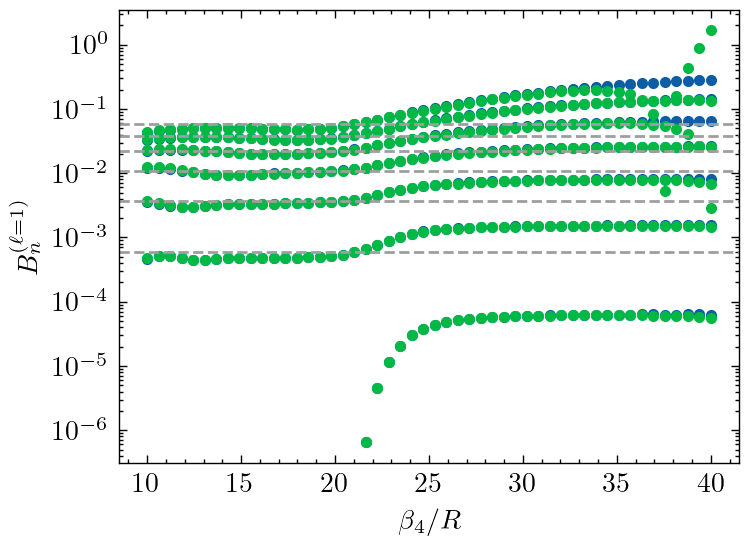

In [7]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

for ((Ri, _), spec) in zip(lo_rg_flow, lo_p_wave):
    for s in spec.lo_evals:
        ax.scatter(const.BETA4/Ri, np.abs(s), color='C0', marker='.')

for ((Ri, _, _), spec) in zip(nlo_rg_flow, nlo_p_wave):
    for s in spec.nlo_evals:
        ax.scatter(const.BETA4/Ri, np.abs(s), color='C1', marker='.')

for mm in mm_p_evals:
    ax.axhline(np.abs(mm), color='C6', linestyle='--')

ax.set_xlabel(r'$\beta_4/R$')
ax.set_ylabel(r'$B_n^{(\ell=1)}$')
ax.set_yscale('log');

In [9]:
d_wave_spectra = []
for (Ri, gi) in tqdm(lo_rg_flow):
    s = LocalSystem(Ri, ell=2)
    d_wave_spectra.append(s.bound_state_spectrum(gi, 0))

100%|███████████████████████████████████████████████████████████████| 50/50 [03:20<00:00,  4.01s/it]


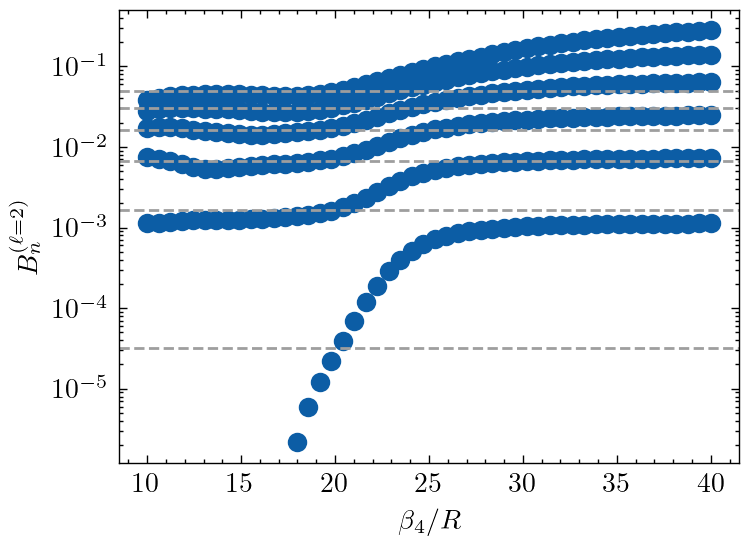

In [18]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

for ((Ri, _), spec) in zip(lo_rg_flow, d_wave_spectra):
    for s in spec:
        ax.scatter(const.BETA4/Ri, np.abs(s), color='C0')

for mm in mm_d_evals:
    ax.axhline(np.abs(mm), color='C6', linestyle='--')
    
ax.set_xlabel(r'$\beta_4/R$')
ax.set_ylabel(r'$B_n^{(\ell=2)}$')
ax.set_yscale('log');